**Summary of EDA and Data Validation**

- 80 features both numerical and categorical. One numerical target. Target should be log10 the provided in data to be 
  able to calculate the RMSLE as required by the scoreboard of the competition
- All missing values except LotFrontage, MasVnrType, MasVnrArea and Electrical have a reason to be missing because a value is 
  not applicable, for example no fence, no pool, no garage in the property. These three columns can be imputed because the   percentage of missing data is less than 20%
- For all categorical columns with missing data except  MasVnrType, NA can be replaced with a "NA" label
- For LotFrontage, the distribution looks like skewed normal --> NA can be replaced by median column value (would be better
  than replacing with the mean)
- MasVnrArea is heavily skewed in distribution with a peak at 0.0 --> impute with median value
- MasVnrType --> impute with mode of the column
- YearRemodAdd: can be used to create another feature column Remod, which should be 1/0 binary according to the 
  rule YearBuilt==YearRemodAdd then 0 else 1
- All year columns should be type int and not treated as a categorical variable to account for the case that test data
  can have different values, example: future purchase dates
- Yrsold: can be used with YearRemodAdd to create a new delta variable of the number of years since renovation at time
  of purchase
- Some categorical variables, like Electrical, have rare labels. An idea is to encode top labels and group others in 
  a new 'Rare' label. The same idea can be used for categorical variables with high cardinality, such as Neighborhood, to
  avoide expanding the feature space too much with possibly no meaningful info
- Nearly all float columns have a high peak at value 0 or are mostly zeros skewing their distributions. Yeo-Johnson can be
  used to attempt bringing the distributions closer to normal (works for all values of x)
- See heatmaps in the last 2 cells for a list of the highest correlated features with sale price target
  


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
raw_data = pd.read_csv("train.csv")

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
raw_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
raw_data.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [6]:
# the percentage of missing values per column
# Check data description for explanation for nulls

print(raw_data.isnull().mean())

Id               0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
Street           0.000000
Alley            0.937671
LotShape         0.000000
LandContour      0.000000
Utilities        0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
OverallQual      0.000000
OverallCond      0.000000
YearBuilt        0.000000
YearRemodAdd     0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
MasVnrType       0.005479
MasVnrArea       0.005479
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
BsmtQual         0.025342
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtFinSF1       0.000000
BsmtFinType2     0.026027
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF 

In [7]:
raw_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

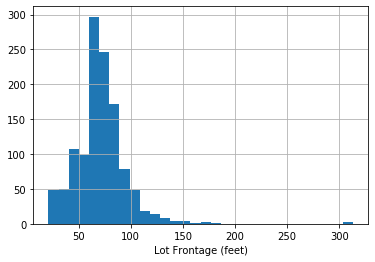

In [8]:
raw_data['LotFrontage'].hist(bins=30)
plt.xlabel("Lot Frontage (feet)");

In [9]:
#Lot Frontage NAs filled with the median value
# Note: since the distribution is skewed to the right, it would be better to impute by median than mean

#raw_data['LotFrontage'].fillna(value=raw_data['LotFrontage'].median(), inplace=True)
#raw_data['LotFrontage'].describe()
#raw_data['LotFrontage'].hist(bins=30)
#plt.xlabel("Lot Frontage (feet)");

In [10]:
#in Alley col NA should be replaced by a string that says 'None' because it means there is no alley access
raw_data["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [11]:
#raw_data["Alley"].fillna(value="None", inplace=True)
#raw_data["Alley"].value_counts()

In [12]:
# checking OverallQual and OverallCond -- probably will need to group them, possibly to 3 groups each: poor, average, high

print(raw_data["OverallCond"].value_counts().sort_index())

print(raw_data["OverallQual"].value_counts().sort_index())

1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64
1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     18
Name: OverallQual, dtype: int64


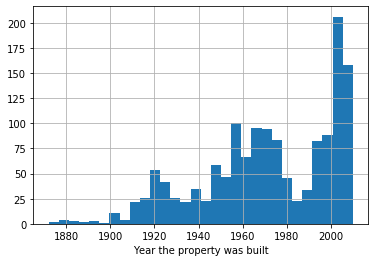

In [13]:
#YearBuilt: should be int type

raw_data["YearBuilt"].hist(bins=30)
plt.xlabel("Year the property was built");

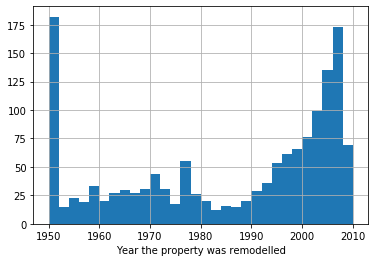

In [14]:
#YearRemodAdd: can be used to create another feature column Remod, which should be 1/0 binary according to the 
#rule YearBuilt==YearRemodAdd then 0 else 1

raw_data["YearRemodAdd"].hist(bins=30)
plt.xlabel("Year the property was remodelled");

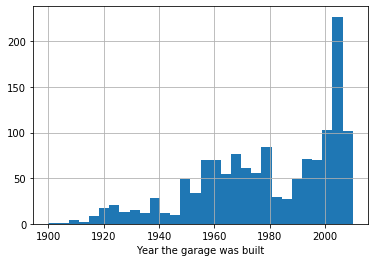

In [15]:
raw_data["GarageYrBlt"].hist(bins=30)
plt.xlabel("Year the garage was built");

In [16]:
# About half the properties in the dataset were remodeled. It would be interesting to see how recent the remodeling was
# referenced to the purchase data

#raw_data["Remod"]=1

#raw_data.loc[raw_data["YearBuilt"]==raw_data["YearRemodAdd"], "Remod"]=0

#raw_data["Remod"].value_counts()

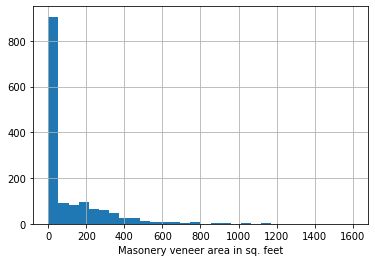

In [17]:
# MasVnrArea have 8 missing values. What does None in MasVnrType correspond to in MasVnrArea ? yes

raw_data["MasVnrArea"].hist(bins=30);
plt.xlabel("Masonery veneer area in sq. feet");

In [18]:
# will assume the 8 missing values are also corresponding to None and 0.0 in MasVnrType and MasVnrArea (mode and median)
#raw_data["MasVnrType"].fillna(value="None", inplace=True)
#raw_data["MasVnrArea"].fillna(value=0.0, inplace=True)

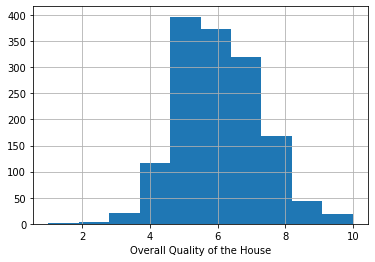

In [19]:
# compare the CDFs of different 0-10 scale variables
raw_data["OverallQual"].hist();
plt.xlabel("Overall Quality of the House");

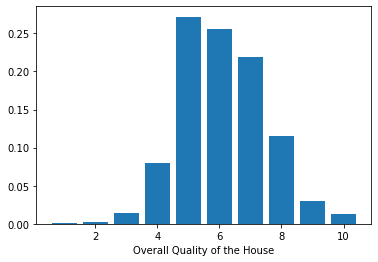

In [20]:
qual = raw_data["OverallQual"]
type(qual)
Pmf.from_seq(qual).bar()
plt.xlabel("Overall Quality of the House");

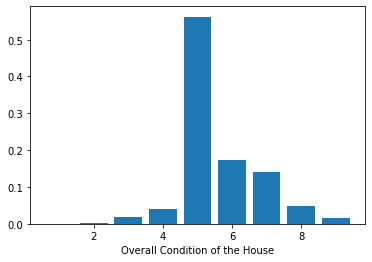

In [21]:
cnd = raw_data["OverallCond"]

Pmf.from_seq(cnd).bar()
plt.xlabel("Overall Condition of the House");

In [22]:
# check all basement related columns 
basement_cols = [x for x in raw_data.columns if "Bsmt" in x]
raw_data[basement_cols].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,443.639726,46.549315,567.240411,1057.429452,0.425342,0.057534
std,456.098091,161.319273,441.866955,438.705324,0.518911,0.238753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,223.000000,795.750000,0.000000,0.000000
50%,383.500000,0.000000,477.500000,991.500000,0.000000,0.000000
75%,712.250000,0.000000,808.000000,1298.250000,1.000000,0.000000
max,5644.000000,1474.000000,2336.000000,6110.000000,3.000000,2.000000


In [23]:
raw_data[basement_cols].describe(include=["O"])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
count,1423,1423,1422,1423,1422
unique,4,4,4,6,6
top,TA,TA,No,Unf,Unf
freq,649,1311,953,430,1256


In [24]:
#raw_data[basement_cols] = raw_data[basement_cols].fillna('None')

In [25]:

# for properties with no basement, null is replace with none in categorical basement columns but the zeros in the numerical
# columns may be replaced by another positive small value, e.g. 1, to make it possible to do a log transformation if needed
# null values donot match 
raw_data.loc[raw_data["BsmtExposure"].isnull(), ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
                                                "BsmtFullBath", "BsmtHalfBath"]]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,0,0,0,0,0,0
39,0,0,0,0,0,0
90,0,0,0,0,0,0
102,0,0,0,0,0,0
156,0,0,0,0,0,0
182,0,0,0,0,0,0
259,0,0,0,0,0,0
342,0,0,0,0,0,0
362,0,0,0,0,0,0
371,0,0,0,0,0,0


In [26]:
#the property with index 948 has null values even though there is a value in basement area. Impute BsmtExposure by mode
raw_data.at[948,"BsmtExposure"]="No"

In [27]:
raw_data.iloc[948]["BsmtExposure"]

'No'

In [28]:
raw_data.loc[raw_data["BsmtExposure"].isnull(), basement_cols].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
count,37.0,37.0,37.0,37.0,37.0,37.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
raw_data.loc[raw_data["BsmtExposure"].isnull(), basement_cols].describe(include=['O'])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
count,0,0,0,0,0
unique,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


In [30]:
# for all the integer columns, plot the PMF

int_cols = [x for x in raw_data.columns if raw_data[x].dtype==np.int64]

int_cols

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

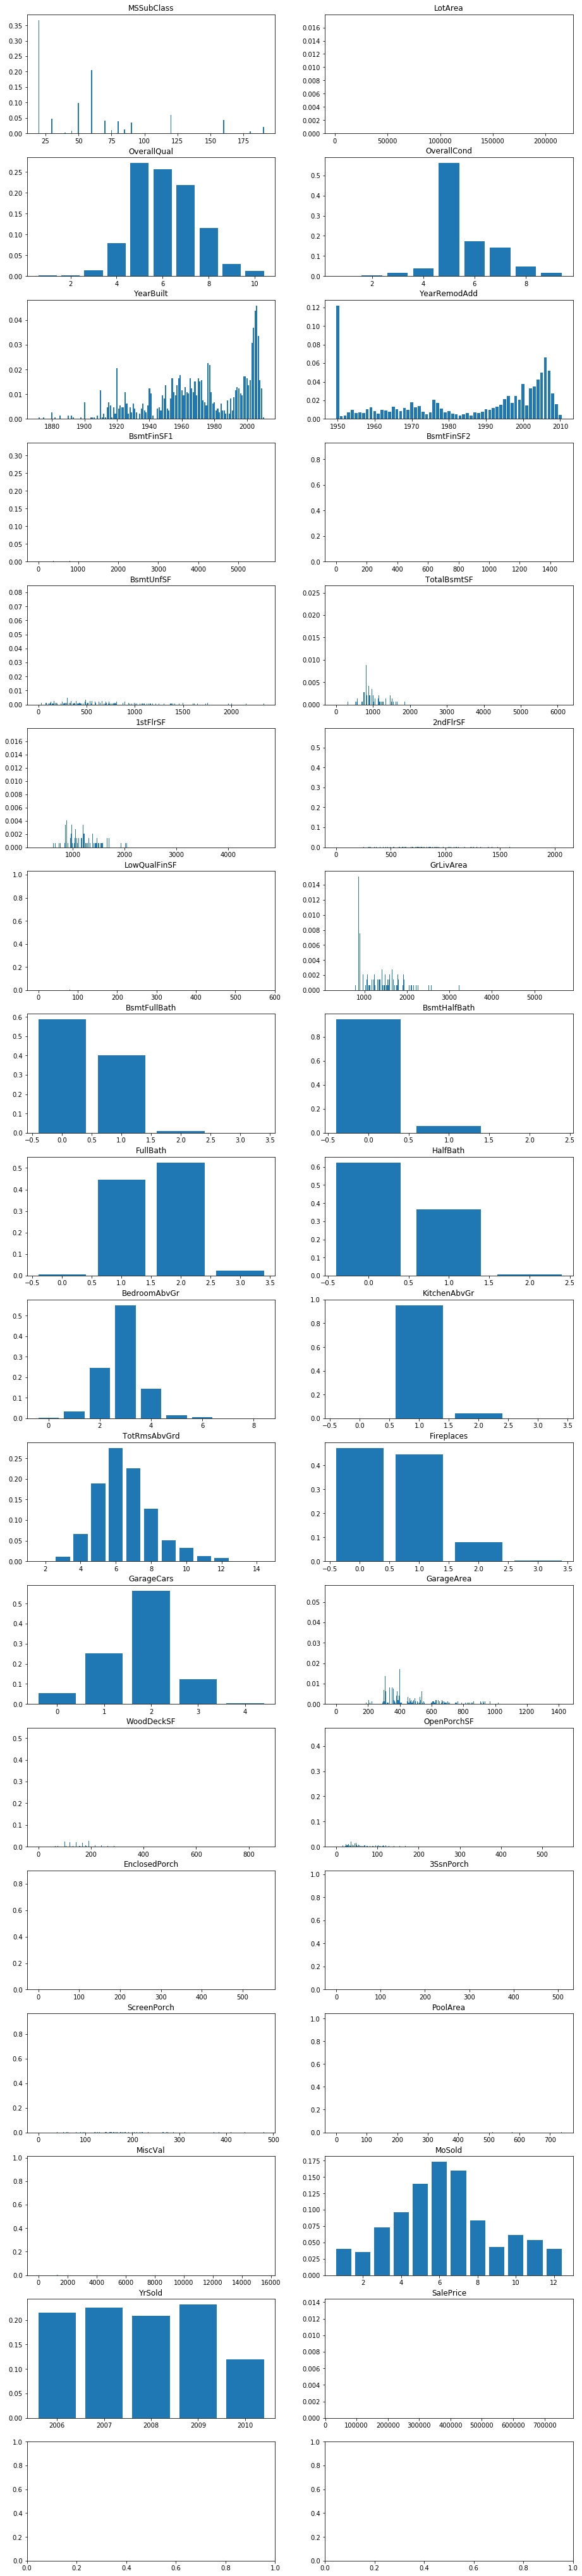

In [31]:
if len(int_cols)%2==0:
    nrows=len(int_cols)//2
else:
    nrows=len(int_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,70))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in int_cols:
    if column=='Id':
        continue
    pmf = Pmf.from_seq(raw_data[column])
    axes[row,col].bar(pmf.qs, pmf.ps)
    axes[row,col].set_title(column)
    
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
     

In [32]:
raw_data["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [33]:
# one missing value in Electrical, impute it to the most common class. May be worth it to group to SBrkr and NonSBrkr

# raw_data["Electrical"]=raw_data["Electrical"].fillna(raw_data["Electrical"].value_counts().index[0])

# raw_data["Electrical"].value_counts()

In [34]:
# Replace all categorical data in numerical form to string

to_string_cols = ["MSSubClass", "MoSold"]

raw_data[to_string_cols] = raw_data[to_string_cols].astype(str)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [35]:
# change int columns that should be float to float
to_float_cols = [x for x in raw_data.columns if ("SF" in x) | ("Area" in x) | ("Porch" in x)]
to_float_cols = to_float_cols+["SalePrice"]+["MiscVal"]
to_float_cols

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'SalePrice',
 'MiscVal']

In [36]:
raw_data[to_float_cols]=raw_data[to_float_cols].astype(np.float64)

In [37]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null float64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 no

In [38]:

cat_cols = [x for x in raw_data.columns if raw_data[x].dtype==np.object]
cat_cols
#raw_data[cat_cols]=raw_data[cat_cols].fillna("None")

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'SaleType',
 'SaleCondition']

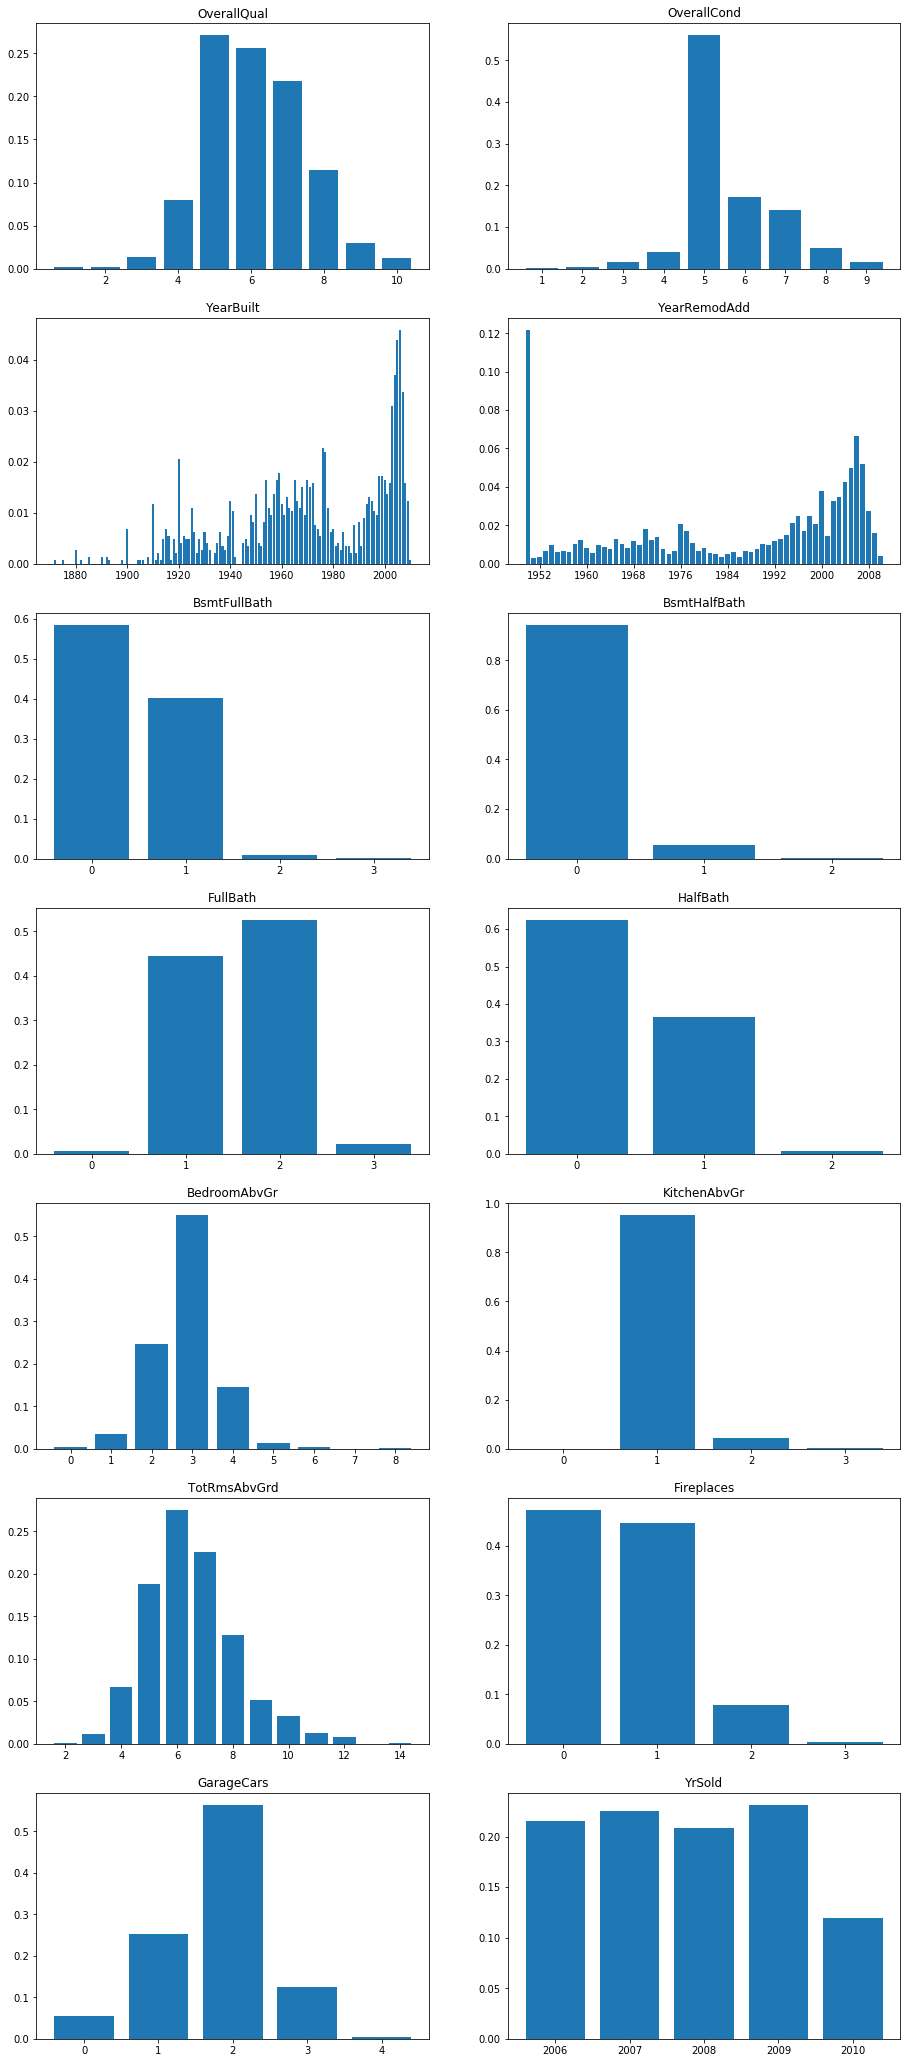

In [39]:
# for all the integer columns, plot the PMF

int_cols = [x for x in raw_data.columns if raw_data[x].dtype==np.int64]
int_cols.remove("Id")

if len(int_cols)%2==0:
    nrows=len(int_cols)//2
else:
    nrows=len(int_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,35))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in int_cols:
    if column=='Id':
        continue
    pmf = Pmf.from_seq(raw_data[column])
    axes[row,col].bar(pmf.qs, pmf.ps)
    axes[row,col].set_title(column)
    axes[row,col].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
 



/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


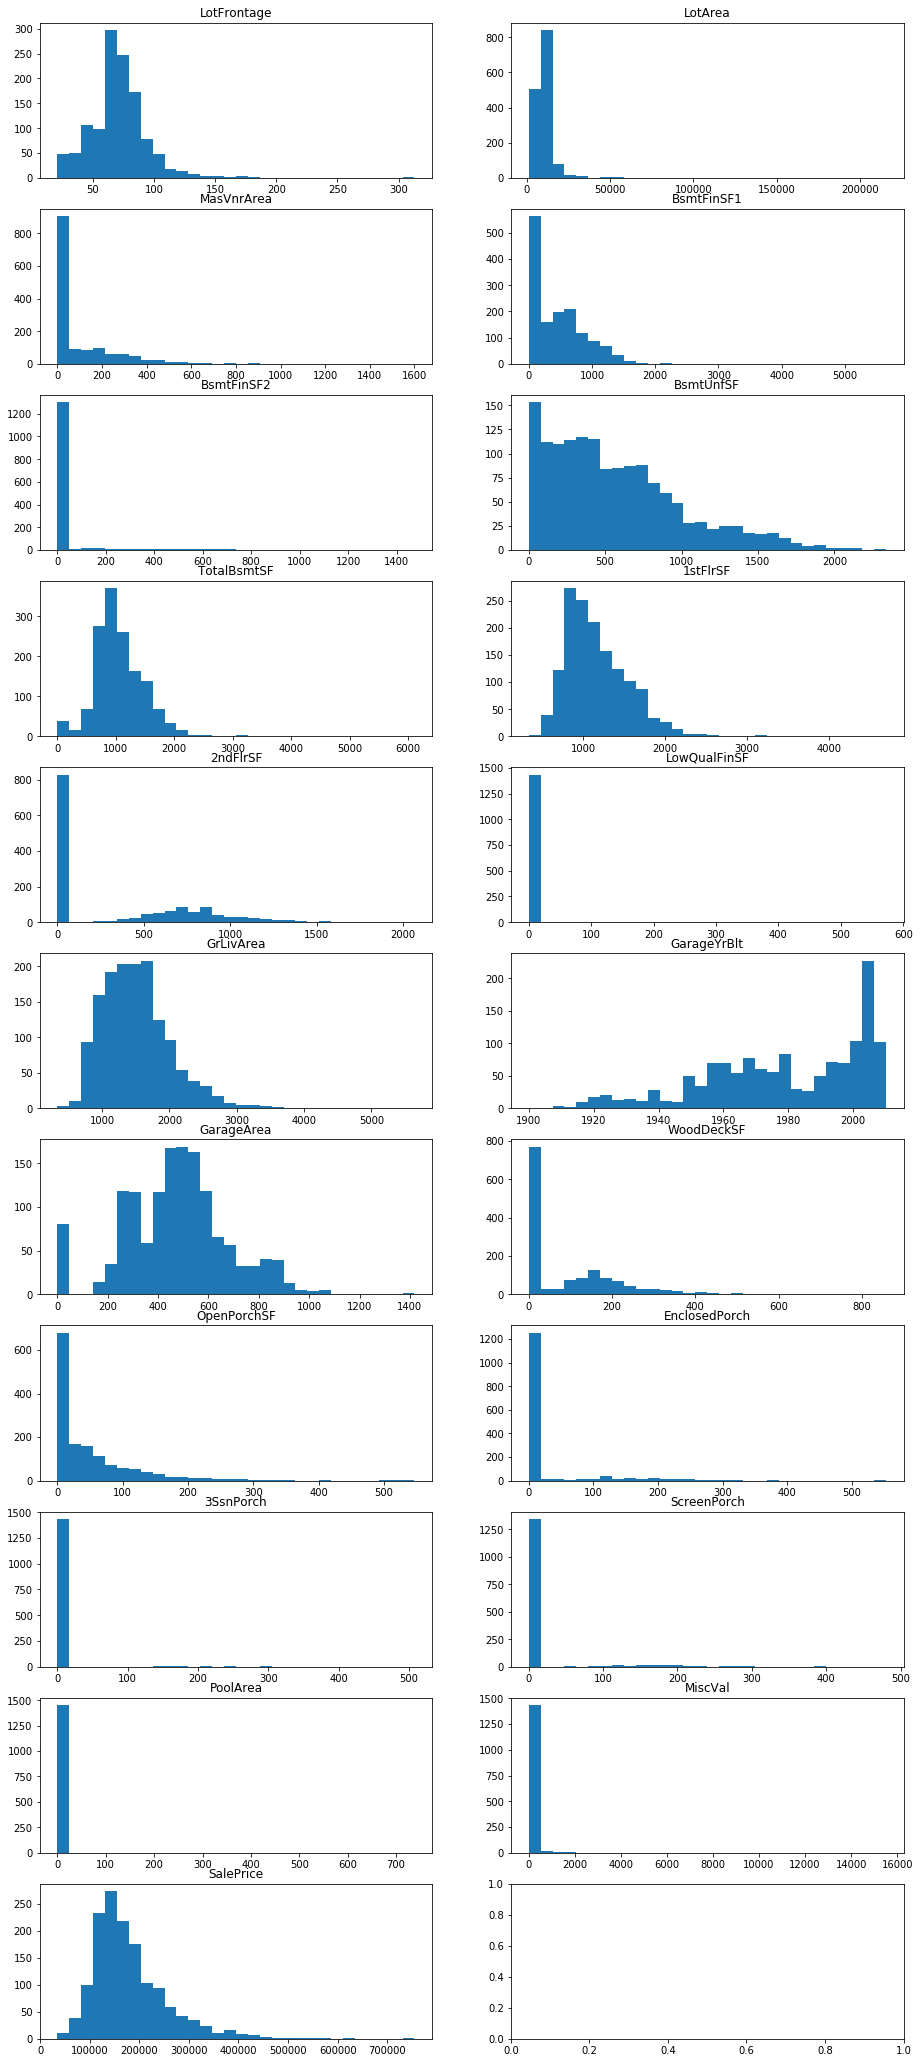

In [40]:
# for all the float columns, plot the distribution and check for presence of outliers

float_cols = [x for x in raw_data.columns if raw_data[x].dtype==np.float64]


if len(float_cols)%2==0:
    nrows=len(float_cols)//2
else:
    nrows=len(float_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,35))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in float_cols:
    
    axes[row,col].hist(raw_data[column], bins=30)
    axes[row,col].set_title(column)
   
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
 

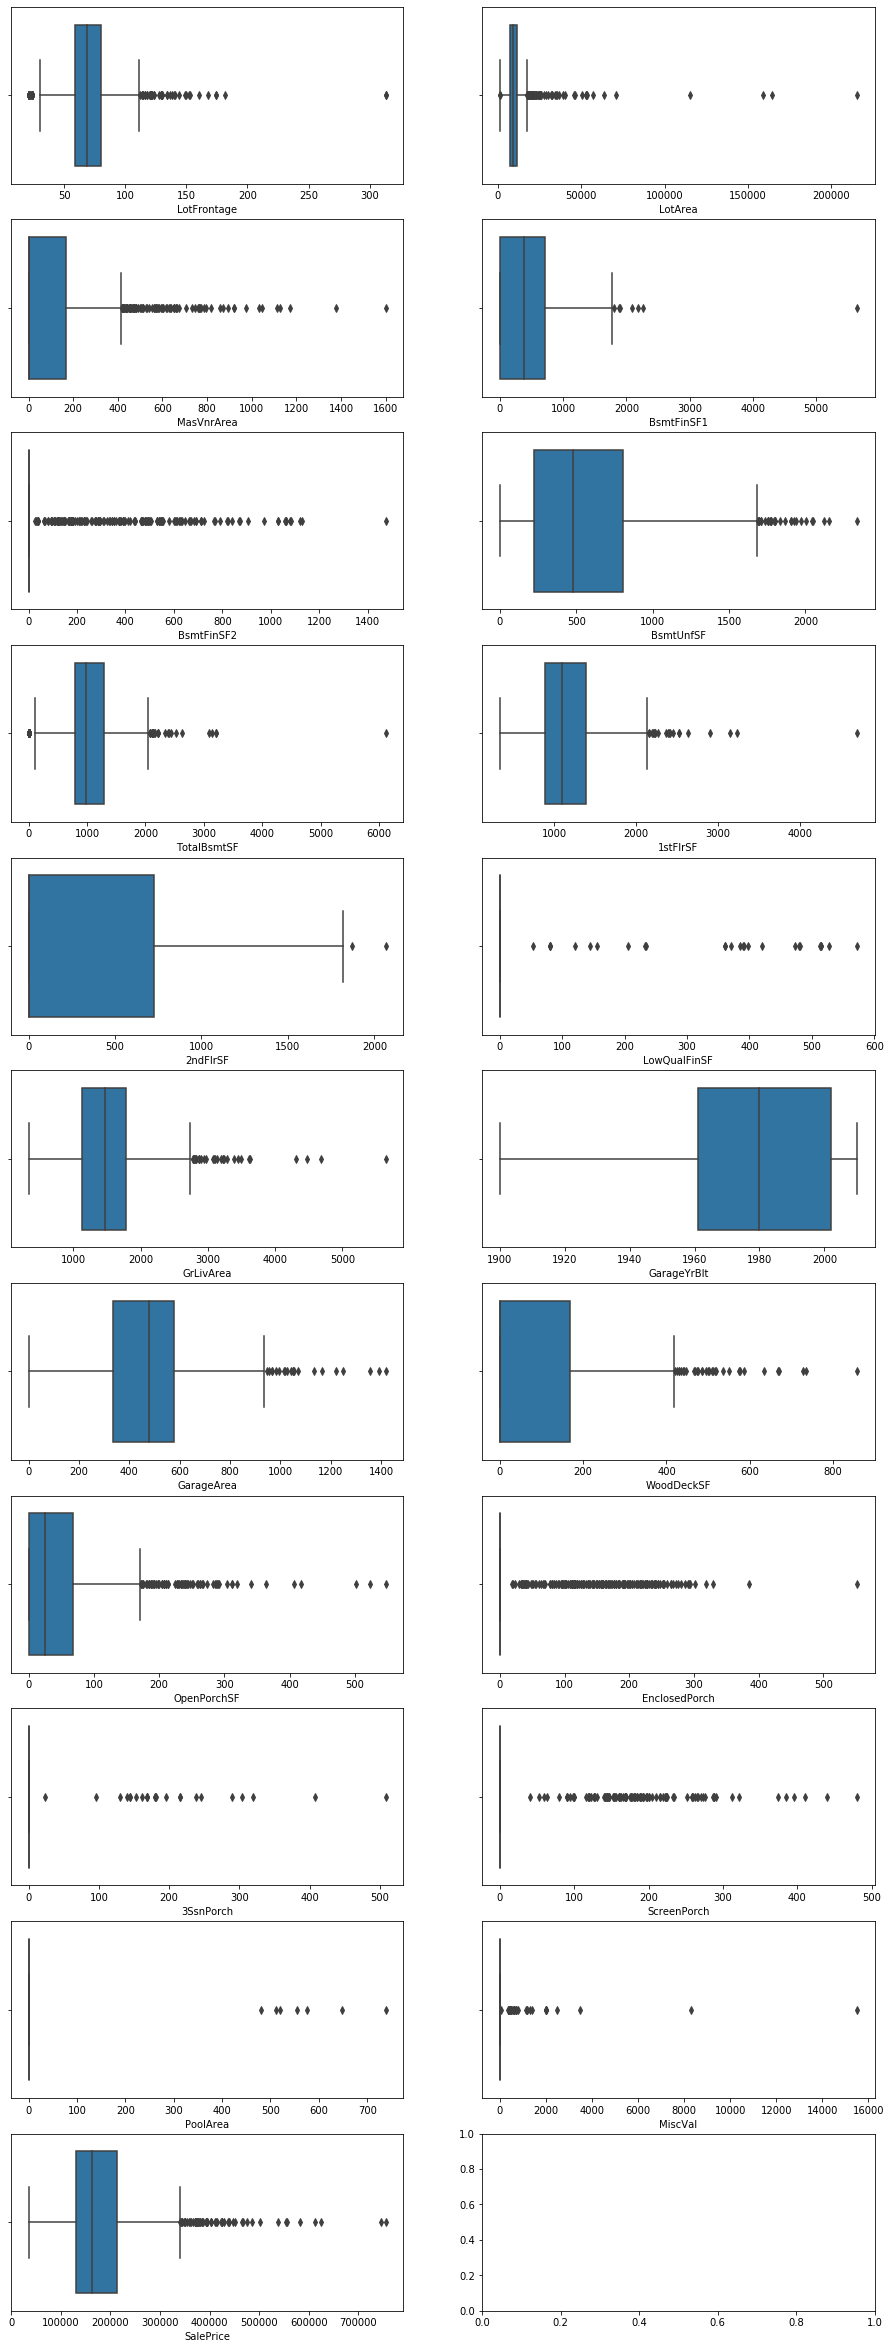

In [41]:
if len(float_cols)%2==0:
    nrows=len(float_cols)//2
else:
    nrows=len(float_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,40))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in float_cols:
    
    sns.boxplot(x=column, data=raw_data, ax=axes[row,col])
    
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
        

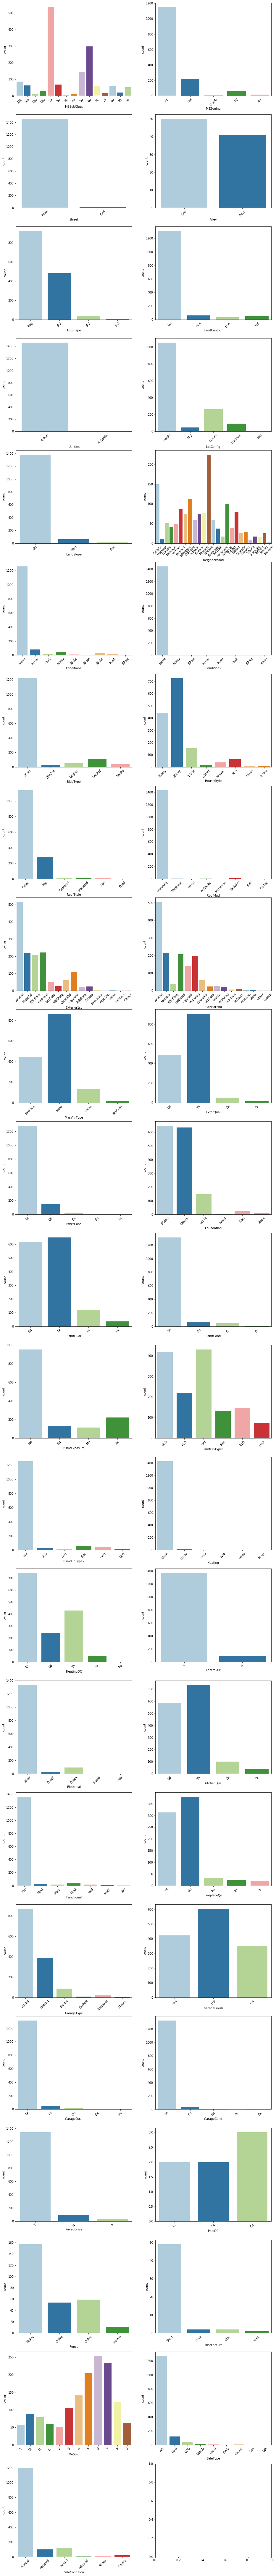

In [42]:
# checking several categorical cols counts for rare labels or possible groupings

cat_cols= [x for x in raw_data.columns if raw_data[x].dtype==np.object]
#print(cat_cols)
if len(cat_cols)%2==0:
    nrows=len(cat_cols)//2
else:
    nrows=len(cat_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,150))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in cat_cols:
    
    sns.countplot(x=column, data=raw_data, palette="Paired", ax=axes[row,col])
    axes[row,col].set_xticklabels(axes[row,col].get_xticklabels(), rotation=45)
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
        

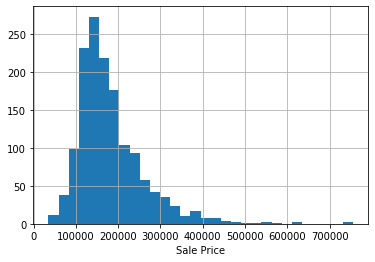

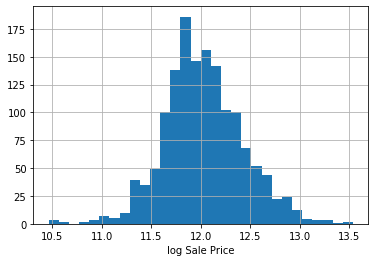

In [43]:
# let's look at the distribution of the target and its log10

raw_data.SalePrice.hist(bins=30)
plt.xlabel("Sale Price")
plt.show()

np.log(raw_data.SalePrice).hist(bins=30)
plt.xlabel("log Sale Price")
plt.show()

/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:1371: RuntimeWarning: invalid value encountered in greater_equal
  pos = x >= 0  # binary mask
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


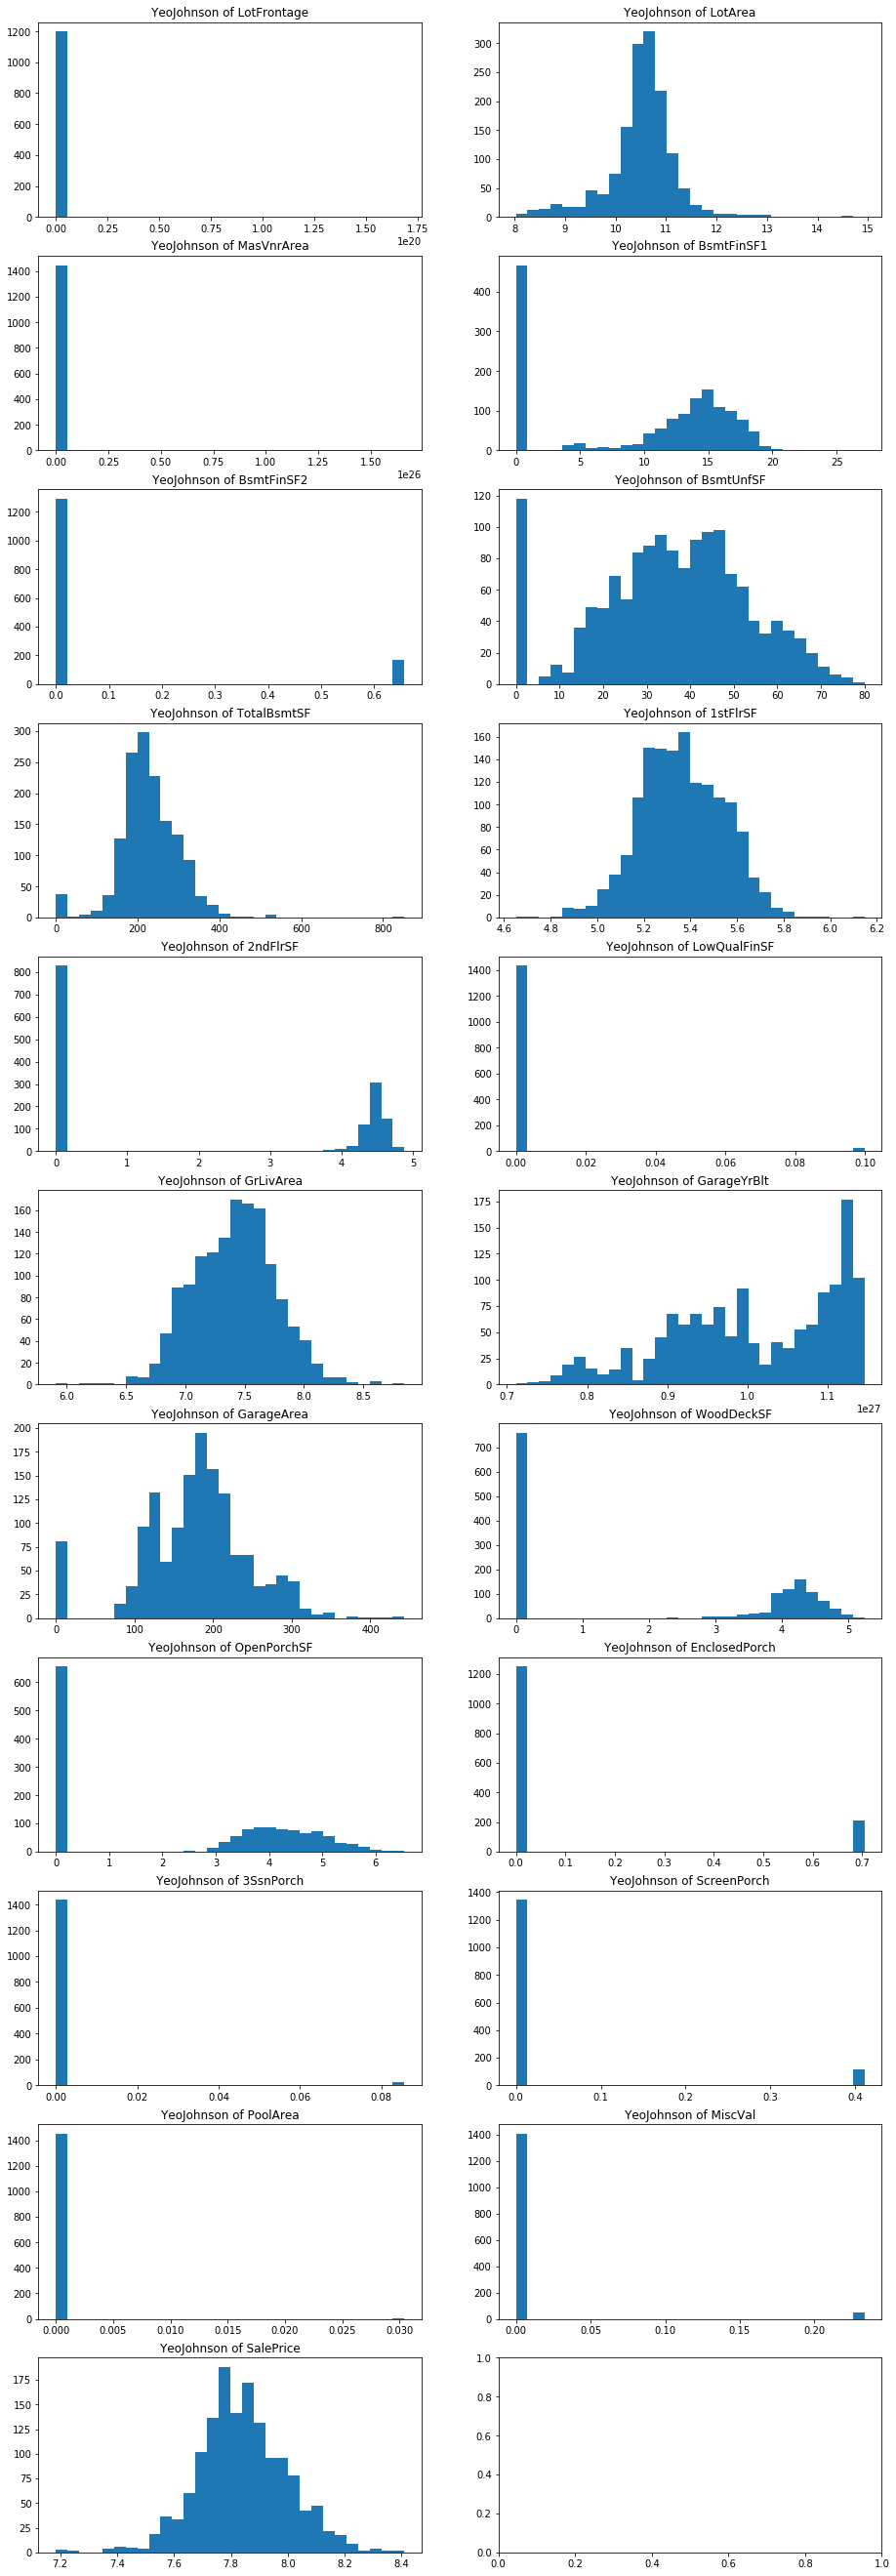

In [44]:
# take another look at the distributions of the float columns after applying Yeo-Johnson transformation
import scipy.stats as stats
if len(float_cols)%2==0:
    nrows=len(float_cols)//2
else:
    nrows=len(float_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,45))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in float_cols:
    transformed_column, opt_lambda = stats.yeojohnson(raw_data[column])
    axes[row,col].hist(transformed_column, bins=30)
    axes[row,col].set_title("YeoJohnson of "+column)
   
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0

In [45]:
# for float columns, check the percentage of zeros 

for column in float_cols:
    print(column)
    print(np.mean(raw_data[column]==0))


LotFrontage
0.0
LotArea
0.0
MasVnrArea
0.5897260273972603
BsmtFinSF1
0.3198630136986301
BsmtFinSF2
0.8856164383561644
BsmtUnfSF
0.08082191780821918
TotalBsmtSF
0.025342465753424658
1stFlrSF
0.0
2ndFlrSF
0.5678082191780822
LowQualFinSF
0.9821917808219178
GrLivArea
0.0
GarageYrBlt
0.0
GarageArea
0.05547945205479452
WoodDeckSF
0.5212328767123288
OpenPorchSF
0.44931506849315067
EnclosedPorch
0.8575342465753425
3SsnPorch
0.9835616438356164
ScreenPorch
0.9205479452054794
PoolArea
0.9952054794520548
MiscVal
0.9643835616438357
SalePrice
0.0


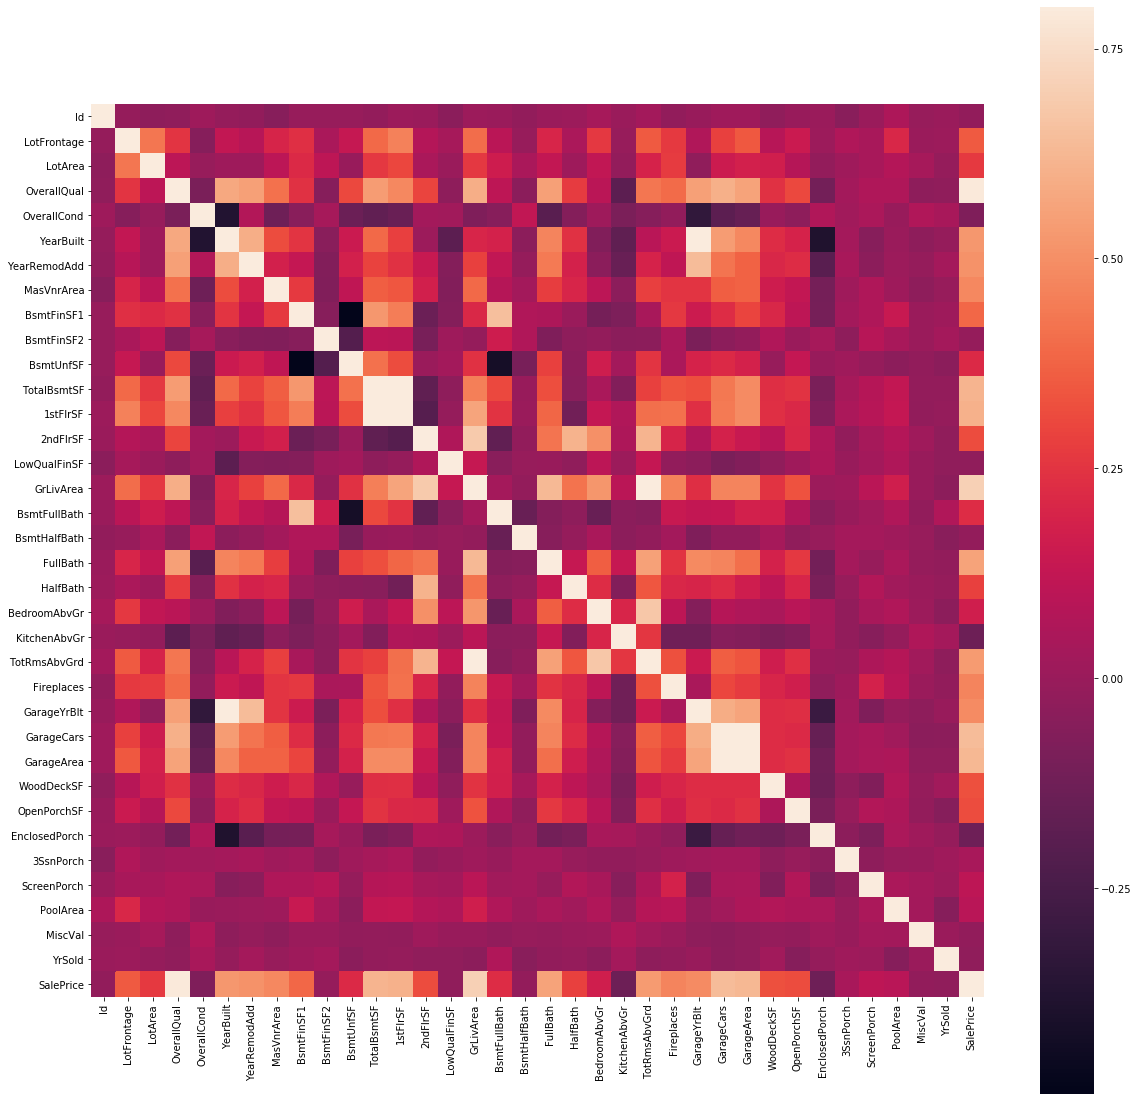

In [46]:
# checking correlations in features and target

#correlation matrix
corrmat = raw_data.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True);

In [47]:
#10 features with highest correlation with target 

corrmat.nlargest(10, 'SalePrice')

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
SalePrice,-0.021917,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,-0.011378,0.214479,0.613581,0.605852,0.319334,-0.025606,0.708624,0.227122,-0.016844,0.560664,0.284108,0.168213,-0.135907,0.533723,0.466929,0.486362,0.640409,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,-0.028923,1.000000
OverallQual,-0.028365,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,-0.027347,0.790982
GrLivArea,0.008273,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,-0.009640,0.240257,0.454868,0.566024,0.687501,0.134683,1.000000,0.034836,-0.018918,0.630012,0.415772,0.521270,0.100063,0.825489,0.461679,0.231197,0.467247,0.468997,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,-0.036526,0.708624
GarageCars,0.016570,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,-0.038264,0.214175,0.434585,0.439317,0.183926,-0.094480,0.467247,0.131881,-0.020891,0.469672,0.219178,0.086106,-0.050634,0.362289,0.300789,0.588920,1.000000,0.882475,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,-0.039117,0.640409
GarageArea,0.017634,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,0.296970,-0.018227,0.183303,0.486665,0.489782,0.138347,-0.067601,0.468997,0.179189,-0.024536,0.405656,0.163549,0.065253,-0.064433,0.337822,0.269141,0.564567,0.882475,1.000000,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,-0.027378,0.623431
TotalBsmtSF,-0.015415,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.322445,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,-0.014969,0.613581
1stFlrSF,0.010496,0.457181,0.299475,0.476224,-0.144203,0.281986,0.240379,0.344501,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,0.566024,0.244671,0.001956,0.380637,-0.119916,0.127401,0.068101,0.409516,0.410531,0.233449,0.439317,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,-0.013604,0.605852
FullBath,0.005587,0.198769,0.126031,0.550600,-0.194149,0.468271,0.439046,0.276833,0.058543,-0.076444,0.288886,0.323722,0.380637,0.421378,-0.000710,0.630012,-0.064512,-0.054536,1.000000,0.136381,0.363252,0.133115,0.554784,0.243671,0.484557,0.469672,0.405656,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,-0.019669,0.560664
TotRmsAbvGrd,0.027239,0.352096,0.190015,0.427452,-0.057583,0.095589,0.191740,0.280682,0.044316,-0.035227,0.250647,0.285573,0.409516,0.616423,0.131185,0.825489,-0.053275,-0.023836,0.554784,0.343415,0.676620,0.256045,1.000000,0.326114,0.148112,0.362289,0.337822,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,-0.034516,0.533723
YearBuilt,-0.012713,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,-0.013618,0.522897


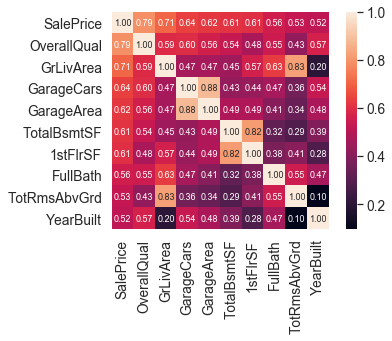

In [48]:
# Zooming in the correlation heatmap for the highest 10 features

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = raw_data[cols].corr()
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, 
                 yticklabels=cols.values, xticklabels=cols.values)
#plt.figure(figsize=(20,20))
plt.show()